### Модель Бакстера-Ву
#### Часть 1
1. Треугольная решетка с переодическими гран. условиями
2. Реализовать алгоритм Метрополис
3. Посчитать энергию на связь

#### Треугольная решетка с периодическими гран. условиями
Имеет вид
\begin{array}{cccc}
&&& \sigma_1 && \sigma_2 && \sigma_3\\
&& \sigma_4 && \sigma_5 && \sigma_6\\
& \sigma_7 && \sigma_8 && \sigma_9\\
\end{array}

И может быть представлена в виде двумерного массива со связями

\begin{array}{cccc}
\sigma_1 && \sigma_2 && \sigma_3\\
\sigma_4 && \sigma_5 && \sigma_6\\
\sigma_7 && \sigma_8 && \sigma_9\\
\end{array}

In [15]:
import numpy as np
import random as rnd
import time
import matplotlib
import matplotlib.pyplot as plt

In [71]:
class BW:
    def __init__(self, L, state):
        self.L = L
        self.J = 1      
        self.N_relax = 10**3
        self.N_avg = 10**3
        self.state = state
        
        self.mask = create_mask(L)
        
        self.e = []    
        self.m = []                                     

    def clear(self):
        """Reinitialize the data structures for the next query after the previous query."""
        self.e = []    
        self.m = [] 
        pass

    def get_jk(self):
        """get random spin in Metropolis Alg."""
        return rnd.randint(0, self.L-1), rnd.randint(0, self.L-1)
    
    def calc_ejk(self,st,j,k):
        """вычисляет энергию спина j,k
        a:  add last line to TOP, first to BOTTOM
        s:  add left line to RIGHT, last to LEFT"""
        a = np.concatenate((st[self.L-1].reshape(1,self.L), st, st[0].reshape(1,self.L)), axis=0) 
        s = np.concatenate((a[:,-1].reshape(self.L+2,1),a,a[:,0].reshape(self.L+2,1)), axis=1)   
        summa = (
            s[j,k-1]*s[j+1,k] +
            s[j+1,k]*s[j+1,k+1] +
            s[j+1,k+1]*s[j,k+1] +
            s[j,k+1]*s[j-1,k] +
            s[j-1,k]*s[j-1,k-1] +
            s[j-1,k-1]*s[j,k-1]
        )
        return -s[j,k]*summa
    
    def flip(self,j,k):
        """перевернуть спин j,k"""
        self.state[j,k] *= -1
        pass
        
    def step(self, K):
        """perform 1 Metropolis step"""
        j,k = self.get_jk()
        e_jk = self.calc_ejk(self.state,j+1,k+1)
        if e_jk > 0:
            self.flip(j,k)
        elif rnd.uniform(1,0) <= np.exp(2*e_jk*K): #uniformly distributed over interval [low, high)
            self.flip(j,k)
        pass
            
    def calc_e(self, st):
        """calculate energy per site
            # expland state matrix"""
        a = np.concatenate((st[self.L-1].reshape(1,self.L), st, st[0].reshape(1,self.L)), axis=0) 
        b = np.concatenate((a[:,-1].reshape(self.L+2,1),a,a[:,0].reshape(self.L+2,1)), axis=1)
        return -np.sum(b[1:-1, 1:-1]*b[2:, 2:]*(b[2:, 1:-1]+b[1:-1, 2:]))/(self.L*self.L)  

    def calc_ms(self, st):
        """magnetization"""
        msr = np.array([np.sum(st[self.mask==i]) for i in [0,1,2]])/(self.L*self.L)
        return np.sqrt(np.sum(msr*msr))
    
    def calc_c(self, T):
        """specific heat"""
        e2_ = np.mean(np.array(self.e)**2)   # <e^2> 
        e_2 = np.mean(self.e)**2             # <e>^2
        return self.L*self.L/(T*T)*(e2_ - e_2)

    def model(self,T):
        self.clear()
        K = J/T
        for _ in range(self.N_avg):        
            for __ in range(self.N_relax):  
                self.step(K)
            self.e += [self.calc_e(self.state)]
            #self.m += [self.calc_ms(self.state)]
        return self.calc_c(T)

        
def gen_state(L):
    """generate random init. state with lenght L*L and q=[-1,1]"""
    rnd.seed(1234)
    return np.array([rnd.choice([-1,1]) for _ in range(L*L)]).reshape(L,L)

def create_mask(L):
    """маска в виде 3 под-решёток"""
    a = np.asarray([i % 3 for i in range(L)])
    return (a + a[:, None])%3

if __name__ == '__main__':
    C = []
    L = 18
    bw = BW(L, gen_state(L))
    t = np.arange(13,33,1.5)/10
    for T in t:
        st = time.time()
        C += [bw.model(T)]
        print('T=',T,': in',time.time()-st,'sec')

T= 1.3 : in 0.34230804443359375 sec
T= 1.45 : in 0.3539559841156006 sec
T= 1.6 : in 0.3552381992340088 sec
T= 1.75 : in 0.35630297660827637 sec
T= 1.9 : in 0.3518249988555908 sec
T= 2.05 : in 0.36372804641723633 sec
T= 2.2 : in 0.3456399440765381 sec
T= 2.35 : in 0.32950496673583984 sec
T= 2.5 : in 0.3525857925415039 sec
T= 2.65 : in 0.34597086906433105 sec
T= 2.8 : in 0.34975314140319824 sec
T= 2.95 : in 0.3455641269683838 sec
T= 3.1 : in 0.35167407989501953 sec
T= 3.25 : in 0.3307619094848633 sec


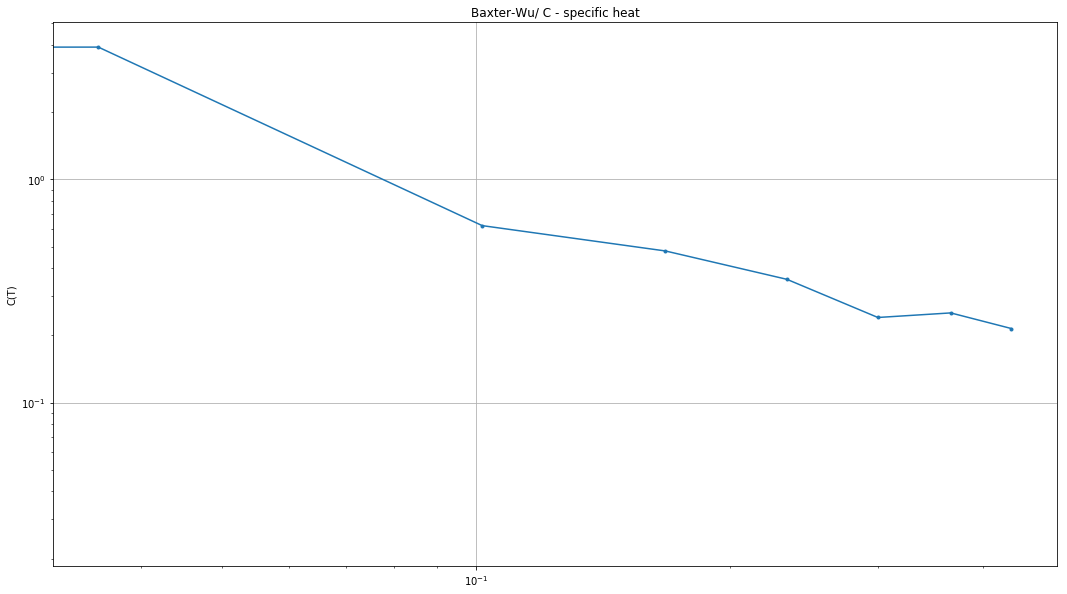

In [92]:
tc = 1/(np.log(2**0.5+1)/2) # 2.269185314213022
t1 = (t-tc)/tc
plt.figure(figsize=(18, 10))

#plt.subplot(2, 1, 1)
plt.plot(t1, C, '.-')
plt.title('Baxter-Wu/ C - specific heat')
plt.ylabel('C(T)')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)

In [81]:
C = np.array([3.687274483161781,
 0.02390511002496667,
 0.05795609567902023,
 0.12852735097020954,
 0.2231790157656201,
 0.43193530012263365,
 1.1443660748903313,
 3.915478421049676,
 0.6207034074074015,
 0.47799279388560123,
 0.3567498110355215,
 0.240615608541605,
 0.25223199085314923,
 0.21463668639053388])
C

array([3.68727448, 0.02390511, 0.0579561 , 0.12852735, 0.22317902,
       0.4319353 , 1.14436607, 3.91547842, 0.62070341, 0.47799279,
       0.35674981, 0.24061561, 0.25223199, 0.21463669])

In [77]:
t1

array([-0.42710717, -0.36100415, -0.29490113, -0.22879811, -0.16269509,
       -0.09659207, -0.03048905,  0.03561396,  0.10171698,  0.16782   ,
        0.23392302,  0.30002604,  0.36612906,  0.43223208])

### Черновик

In [9]:
def gen_state(L, q):
#generate random init. state with lenght L*L and q=[-1,1]
    rnd.seed(1234)
    state = np.array([rnd.choice(q) for _ in range(L*L)]).reshape(L,L)
    #np.random.seed(None)
    return state

def get_jk():
#get random spin in Metropolis Alg.
    return rnd.randint(0, L-1), rnd.randint(0, L-1)

def calc_e(state):
    a = np.concatenate((state[L-1].reshape(1,L), state, state[0].reshape(1,L)), axis=0) 
    b = np.concatenate((a[:,-1].reshape(L+2,1),a,a[:,0].reshape(L+2,1)), axis=1)
    return -np.sum(b[1:-1, 1:-1]*b[2:, 2:]*(b[2:, 1:-1]+b[1:-1, 2:]))/(L*L)  
